# Pythagorean Triples via Grover's Algorithm
##### Elijah Kin
Here we attempt to generate Pythagorean triples on a quantum computer by means of Grover's algorithm.

In [1]:
import numpy as np
import qiskit

from heapq import nlargest
from qiskit import transpile, QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.circuit.library import MultiplierGate, HalfAdderGate
from qiskit.visualization import plot_histogram

In [2]:
print(qiskit.__version__)

# backend = Aer.get_backend('aer_simulator')
backend = Aer.get_backend('aer_simulator_matrix_product_state')

1.3.2


### Squaring a Register
We will first design a circuit which sends $|a\rangle |0\rangle \mapsto |a\rangle |a^2\rangle$. This idea will serve as the basis for our Pythagorean oracle later.

In [3]:
# Create circuit for squaring a
def SquareGate(n):
  qc = QuantumCircuit(4 * n)
  # Probably not the most efficient way to do this...
  qc.cx(range(n), range(n, 2 * n))
  return qc.compose(MultiplierGate(n))

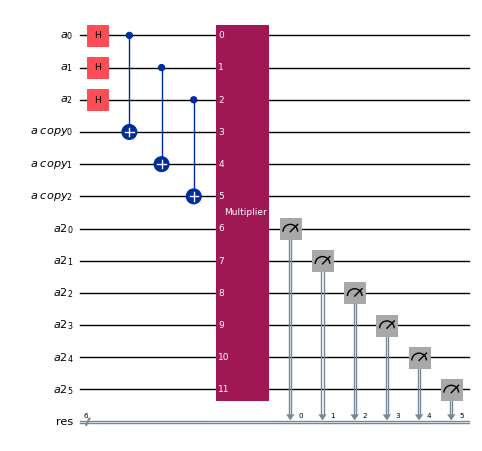

In [4]:
n = 3
qr_a = QuantumRegister(n, name='a')
ar_a = AncillaRegister(n, name='a copy')
qr_a2 = QuantumRegister(2 * n, name='a2')
cr_a2 = ClassicalRegister(2 * n, name='res')

qc = QuantumCircuit(qr_a, ar_a, qr_a2, cr_a2)
qc.h(qr_a)
qc.compose(SquareGate(len(qr_a)), inplace=True)
qc.measure(qr_a2, cr_a2)

qc.draw('mpl', scale=0.5)

In [5]:
qc_opt = transpile(qc, backend=backend, optimization_level=2)

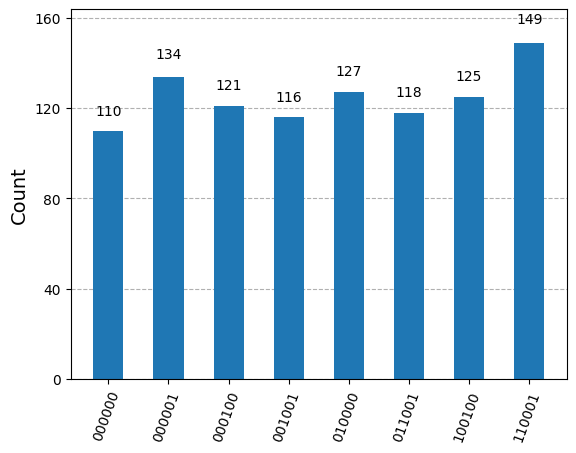

In [6]:
results = backend.run(qc_opt, shots=1000).result()
plot_histogram(results.get_counts())

We see that the above indeed works; the measured states correspond exactly to the perfect squares: $0, 1, 4, 9, 16, 25, 36, 49$

### Designing the Oracle
We will first implement a circuit that, given nine qubits denoting $a$, $b$, and $c$ in binary, will check whether $a^2 + b^2 = c^2$. In particular, we use the same technique as above, using `cx` gates to duplicate $a$, $b$, and $c$ before applying `MultiplierGate` to compute each of $a^2$, $b^2$, and $c^2$. To conserve qubits we also use `reset` gates.

In [7]:
# Oracle that returns 1 if a Pythagorean triple is found
def oracle_pythag(n):
  # Needs 4n qubits to compute each square
  qc = QuantumCircuit(8 * n + 2, 10)

  # Make copies of a, b, and c and compute the squares a^2, b^2, and c^2
  qc.cx([0, 1, 2], [9, 10, 11])
  qc.compose(MultiplierGate(n), [0, 1, 2] + [9, 10, 11] + [12, 13, 14, 15, 16, 17], inplace=True)
  qc.reset([9, 10, 11])

  qc.cx([3, 4, 5], [9, 10, 11])
  qc.compose(MultiplierGate(n), [3, 4, 5] + [9, 10, 11] + [18, 19, 20, 21, 22, 23], inplace=True)
  qc.reset([9, 10, 11])

  # Add a^2 and b^2
  qc.compose(HalfAdderGate(2 * n), qubits=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], inplace=True)
  qc.reset([12, 13, 14, 15, 16, 17])

  qc.cx([6, 7, 8], [9, 10, 11])
  qc.compose(MultiplierGate(n), [6, 7, 8] + [9, 10, 11] + [12, 13, 14, 15, 16, 17], inplace=True)

  # Check if each qubit of a^2 + b^2 and c^2 are equal
  qc.cx([12, 13, 14, 15, 16, 17], [18, 19, 20, 21, 22, 23])
  qc.x([18, 19, 20, 21, 22, 23, 24])

  # MCX on all equality qubits
  qc.mcx([18, 19, 20, 21, 22, 23, 24], 25)
  return qc

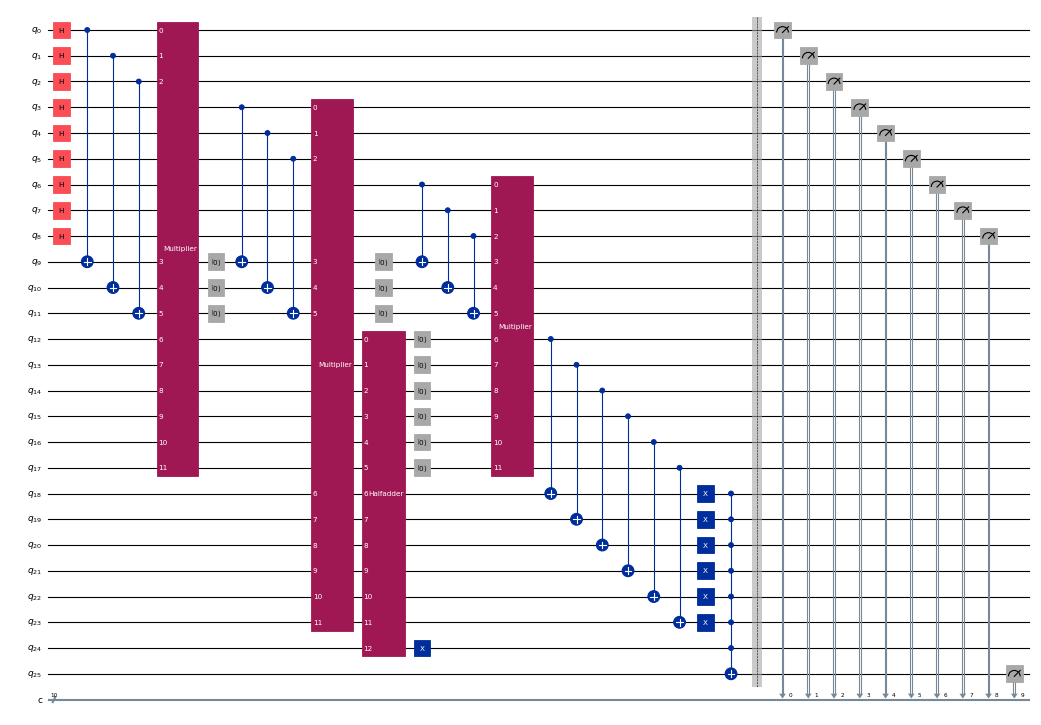

In [8]:
qc_pythag = QuantumCircuit(8 * n + 2, 10)
qc_pythag.h(range(9))
qc_pythag.compose(oracle_pythag(3), inplace=True)
qc_pythag.barrier()
qc_pythag.measure(list(range(9)) + [25], range(10))
qc_pythag.draw('mpl', fold=-1, scale=0.4)

In [9]:
qc_pythag_opt = transpile(qc_pythag, backend=backend, optimization_level=2)

To ensure that our circuit is performing the correct calculation, we will run it in equal superposition on the nine qubits representing $a$, $b$, and $c$ with $300$ shots. We then measure those nine qubits along with the last qubit, which denotes whether $a$, $b$, and $c$ form a Pythagorean triple. We can then verify that $a$, $b$, and $c$ indeed form a triple whenever this last qubit is $1$.

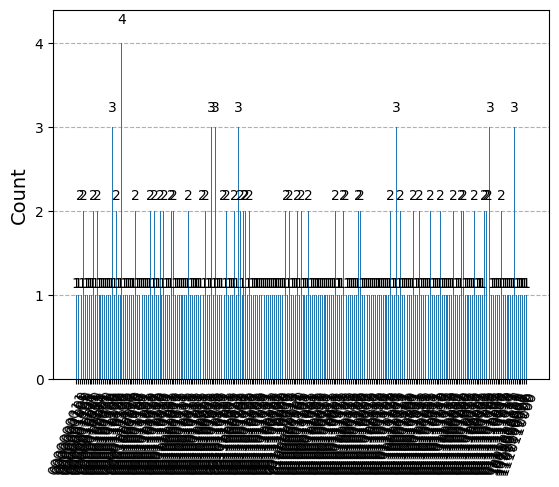

In [10]:
results = backend.run(qc_pythag_opt, shots=300).result()
plot_histogram(results.get_counts())

In [11]:
# Classically postprocess the measured bitstrings
def parse_key(key):
  args = ['a', 'b', 'c']
  vals = sorted([int(key[i : i + 3], base=2) for i in range(1, len(key), 3)])
  return ''.join([f'{arg}={val} ' for arg, val in zip(args, vals)])

for key in results.get_counts().keys():
  if key[0] == '1':
    print(parse_key(key))

a=0 b=4 c=4 
a=3 b=4 c=5 
a=0 b=3 c=3 
a=0 b=1 c=1 
a=0 b=2 c=2 
a=0 b=6 c=6 
a=0 b=0 c=0 


From the triples measured above, we see that our circuit indeed is working correctly. We measure several degenerate Pythagorean triples such as $0^2 + 6^2 = 6^2$, as well as the honest triple $3^2 + 4^2 = 5^2$.

### Implementing Grover's Algorithm
To apply Grover's algorithm we will create an equal superposition of the qubits representing $a$, $b$, $c$, before for each iteration applying the Pythagorean oracle followed by a Grover diffuser. The hope is that then when we measure, the most frequently measured bit strings will correspond to Pythagorean triples.

In [12]:
# Diffusion (sandwiched reflection) operator

def diffuser(q, label='diffuser'):
    qc = QuantumCircuit(q)
    n = qc.num_qubits
    qc.h([q[i] for i in range(n-1)])
    qc.x([ q[i] for i in range(n-1) ])
    if n > 2:
        # for multi-controlled Z use multi-controlled Z rotation
        qc.mcrz(np.pi, q[0:n-2], q[n-2])
    else:
        # for one-qubit oracles no controls
        qc.z(q[0])
    qc.barrier()
    qc.x([ q[i] for i in range(n-1) ])
    qc.h([ q[i] for i in range(n-1) ])
    return qc

In [13]:
def grover(nqubits, oracle, iterations=1, measure=True):

    q = QuantumRegister(nqubits, name='q') # create the quantum register
    if(measure):
    # measure only qubits that are input to the oracle
        creg = ClassicalRegister(10, name='c')
        qc = QuantumCircuit(q,creg)         # create the circuit
    else:
        qc = QuantumCircuit(q)           # circuit without measurements

    # initialize the circuit:
    # the qubit that receives the oracle output must be set to |1>
    qc.x(nqubits-1)
    qc.h(range(9))

    # add repetitions of oracle plus diffusion operator
    for i in range(iterations):
        qc.compose(oracle, inplace=True)
        qc.barrier()
        qc.compose(diffuser(QuantumRegister(10)), list(range(9)) + [25], inplace=True)

    if(measure):  # Measurements
        qc.measure(list(range(9)) + [nqubits - 1],creg)
    return qc

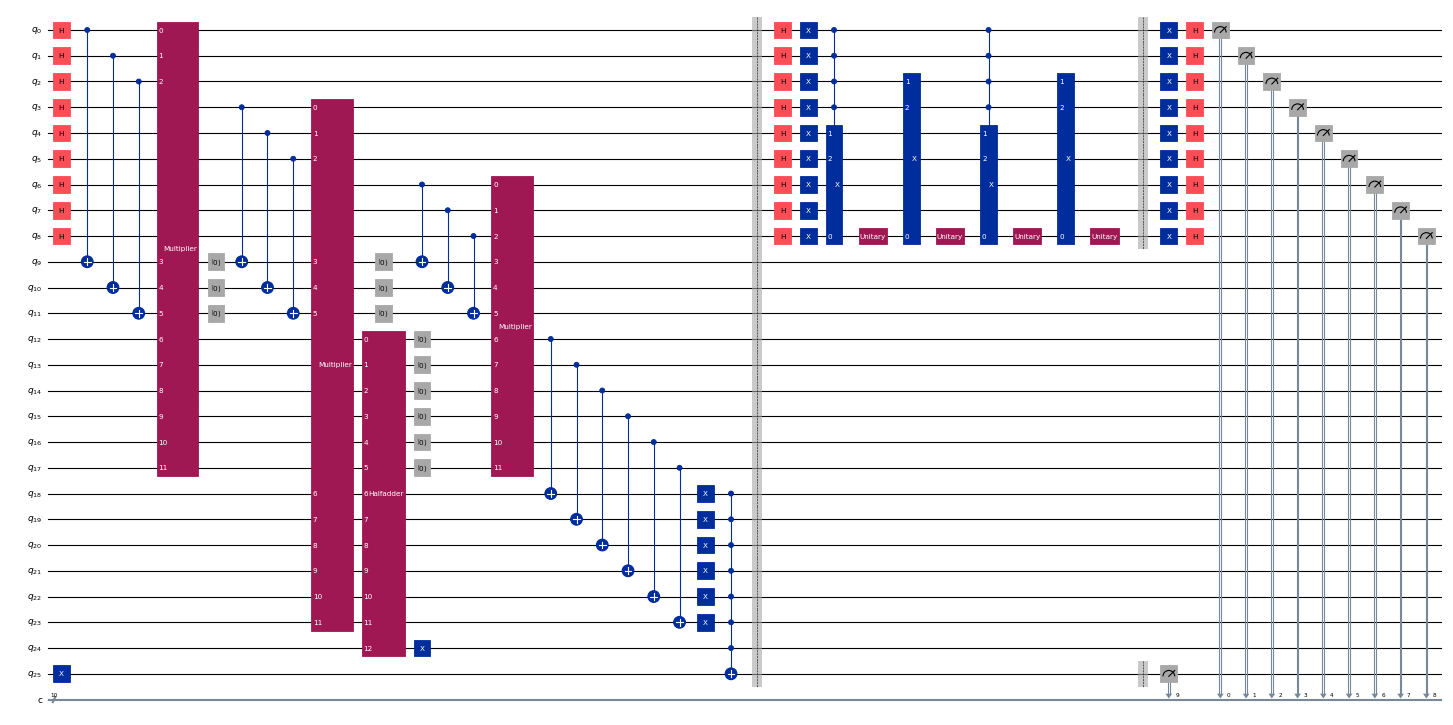

In [14]:
nqubits = 26

qc_grover = grover(nqubits, oracle_pythag(3), iterations=1)
qc_grover.draw(output = 'mpl', fold=-1, scale=0.4)

In [15]:
qc_grover_opt = transpile(qc_grover, backend=backend, optimization_level=2)

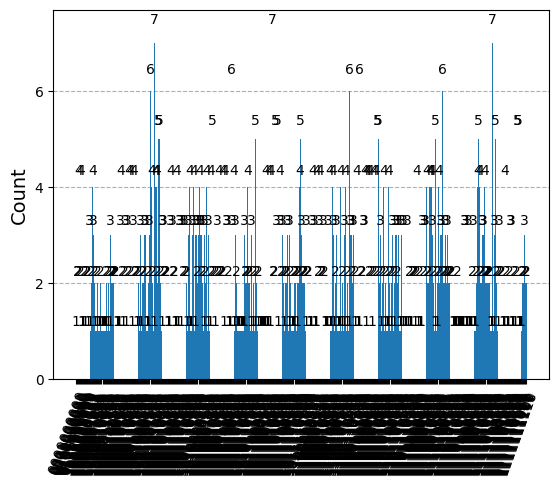

In [16]:
results = backend.run(qc_grover_opt, shots=1000).result()
plot_histogram(results.get_counts())

In [17]:
for key, value in nlargest(5, results.get_counts().items(), key=lambda item: item[1]):
  print(parse_key(key), results.get_counts()[key])

a=0 b=3 c=7  7
a=1 b=3 c=5  7
a=1 b=1 c=2  7
a=4 b=5 c=6  6
a=3 b=3 c=6  6


TODO Not returning sensible results!